# Fitting a donut distribution with a normalizing flow

This notebook shows how to fit a simple, 2-dimensional probability density function using a normalizing flow.

In [1]:
import torch
import torch.optim as optim
from torch.distributions import Normal
print(f'Pytorch version {torch.__version__}')

import numpy as np
import sys
import matplotlib
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = 'TRUE'


Pytorch version 1.5.1


We import `flow_torch.py`, which contains our normalizing flow implementation and several useful utility functions:

In [2]:
sys.path.append('../scripts/')
import flow_torch


# Generate mock data

We draw points from a 2D distribution that we'll refer to as "the donut." In polar coordinates, we draw
$$
  r \sim \mathcal{N} \left( 1, \sigma \right) \, ,
  \\
  \theta \sim \mathcal{U} \left( 0, 2\pi \right) \, ,
$$
where $\sigma \ll 1$, so that $r > 0$. We choose $\sigma = 0.1$. The density corresponding to this distribution is
$$
  p \left( r , \theta \right) =
    \frac{1}{\left( 2 \pi \right)^{3/2} \sigma r} \,
    e^{-\frac{\left( r - 1 \right)^2}{2 \sigma^2}}
  \, .
$$

In [3]:
def sample_true(n, sigma=0.1):
    """
    Draws n samples from the donut distribution. Returns
    a tensor containing (x,y)-coordinates, with shape (n,2).
    """
    r = np.random.normal(1.0, sigma, size=n)
    theta = np.random.uniform(0., 2.*np.pi, size=n)
    x = r * np.cos(theta)
    y = r * np.sin(theta)

    q = np.stack([x,y], axis=1).astype('f4')
    return torch.Tensor(q)

def p_true(y):
    """
    Returns the true p(y) at the given points y.
    """
    r = np.sqrt(y[:,0]**2+y[:,1]**2)
    return np.exp(-0.5*((r-1.)/0.1)**2) / r

In [4]:
n_samples = 1024 * 1024
data = sample_true(n_samples)

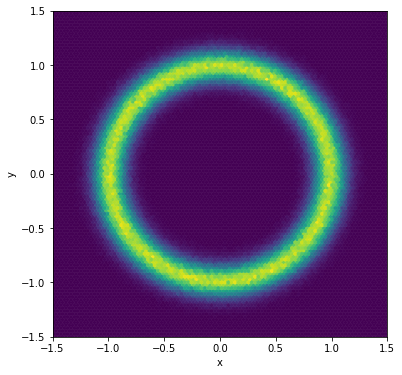

In [5]:
xlim = (-1.5, 1.5)
fig,ax = plt.subplots(1,1, figsize=(6,6))
ax.hexbin(data[:,0], data[:,1], extent=xlim+xlim, lw=0.5)
ax.set_xlim(xlim)
ax.set_ylim(xlim)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

# Train normalizing flow

We now generate and train normalizing flow on this data:

In [6]:
n_dim = 2
n_units = 8 # Number of (inv1x1conv + RQS) units to chain
flow = flow_torch.NormalizingFlow(n_dim, n_units)
callback = flow_torch.get_training_callback(
    flow,
    every=512,
    p_true_fn=p_true
)
loss_history = flow_torch.train_flow(
    flow, data,
    callback=callback
)

../torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)


Step     1 of 32768: <loss> = 2.97630 , lr = 0.02
Step   513 of 32768: <loss> = 1.12575 , lr = 0.01806
Step  1025 of 32768: <loss> = 1.09285 , lr = 0.01631
Step  1537 of 32768: <loss> = 1.09629 , lr = 0.01472
Step  2049 of 32768: <loss> = 1.03137 , lr = 0.01329
Step  2561 of 32768: <loss> = 1.05778 , lr = 0.01198
Step  3073 of 32768: <loss> = 1.10293 , lr = 0.01082
Step  3585 of 32768: <loss> = 1.03173 , lr = 0.009767
Step  4097 of 32768: <loss> = 1.03287 , lr = 0.008819
Step  4609 of 32768: <loss> = 1.03200 , lr = 0.007963
Step  5121 of 32768: <loss> = 1.01092 , lr = 0.007176
Step  5633 of 32768: <loss> = 1.01045 , lr = 0.006479
Step  6145 of 32768: <loss> = 0.96614 , lr = 0.00585
Step  6657 of 32768: <loss> = 1.01508 , lr = 0.005283
Step  7169 of 32768: <loss> = 0.99440 , lr = 0.00477
Step  7681 of 32768: <loss> = 0.98650 , lr = 0.004298
Step  8193 of 32768: <loss> = 0.97485 , lr = 0.003881
Step  8705 of 32768: <loss> = 0.99205 , lr = 0.003504
Step  9217 of 32768: <loss> = 0.93496 , 

Save the trained normalizing flow:

In [7]:
torch.save(flow.state_dict(), 'donut_flow.pth')


It's possible to load the flow from this file later:

In [8]:
state_dict = torch.load("donut_flow.pth")
flow.load_state_dict(state_dict)

<All keys matched successfully>

# Plot results

First, we plot the loss history:

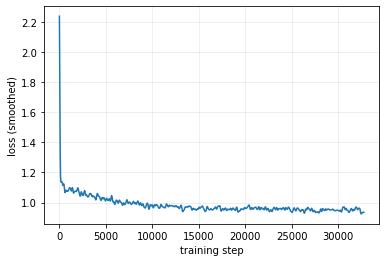

In [9]:
w = np.kaiser(250,5)
w /= np.sum(w)
loss_conv = np.hstack([
    np.repeat(loss_history[0], 125),
    np.array(loss_history),
    np.array(loss_history)[-125:][::-1]
])
loss_conv = np.convolve(loss_conv, w, mode='valid')
plt.plot(np.arange(len(loss_conv)), loss_conv)
plt.grid('on', alpha=0.25)
plt.ylabel('loss (smoothed)')
plt.xlabel('training step')
plt.show()

Then, we visualize the normalizing flow:

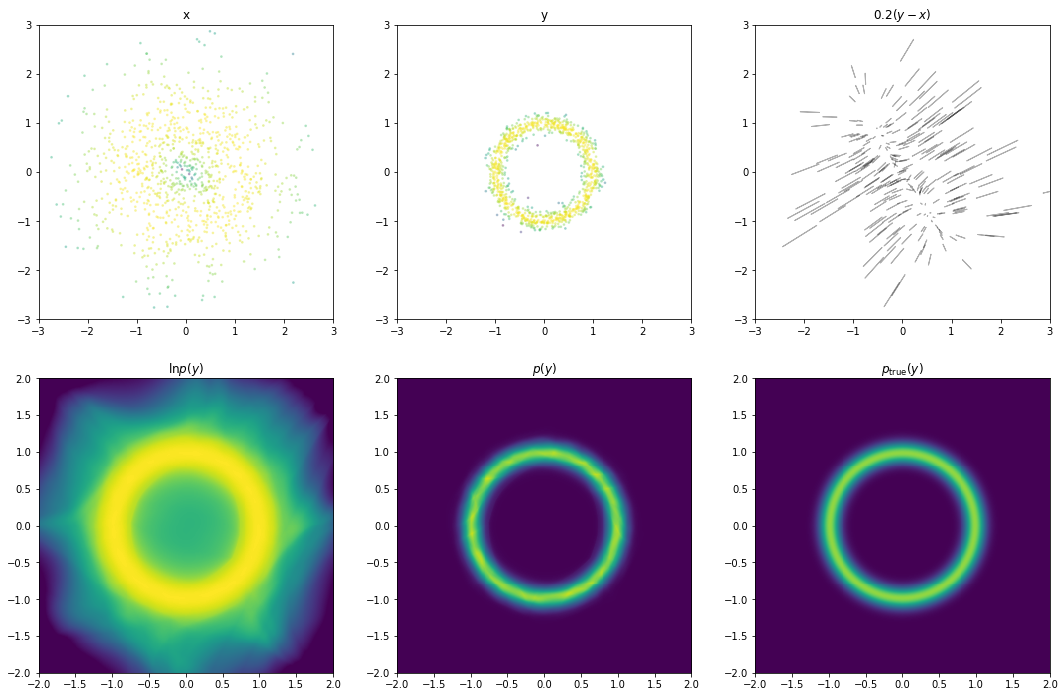

In [10]:
fig = flow_torch.get_flow_plot_fn(flow, p_true_fn=p_true)()
plt.show()

We can also visualize the bijectors in the flow:

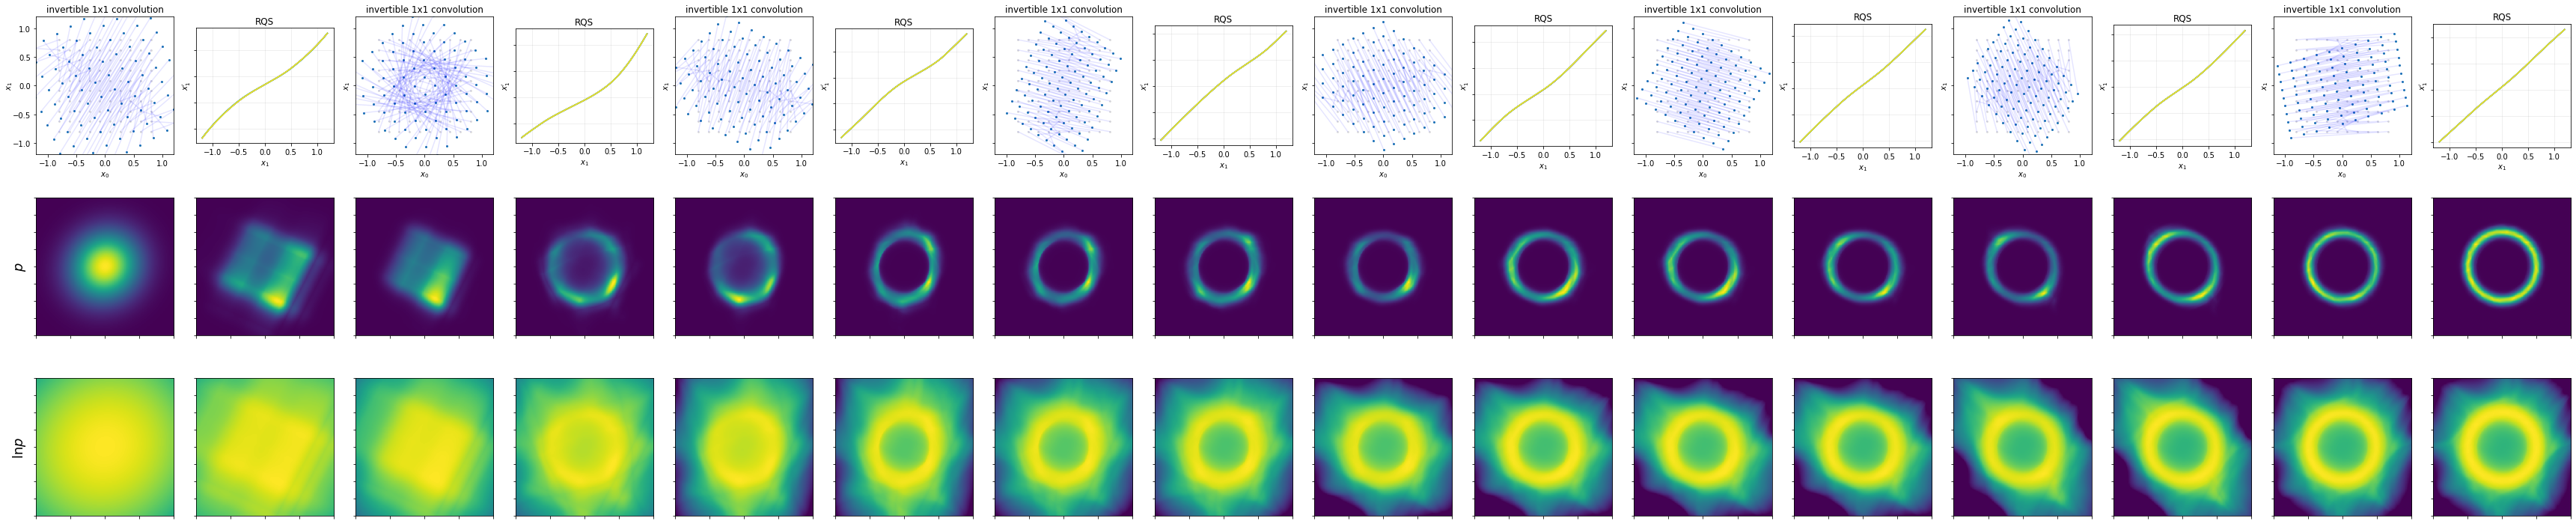

In [11]:
fig = flow_torch.plot_bijections(flow)

Finally, we can turn the images of the normalizing flow that were generated during training into a video:

In [12]:
!ffmpeg -y -r 10 -pattern_type glob -i 'nvp_*.png' -c:v libx264 -vf fps=10 -pix_fmt yuv420p flow_training.mp4

ffmpeg version 4.2.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.8)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.2.1_1 --enable-shared --enable-pthreads --enable-version3 --enable-avresample --cc=clang --host-cflags='-I/Library/Java/JavaVirtualMachines/adoptopenjdk-13.jdk/Contents/Home/include -I/Library/Java/JavaVirtualMachines/adoptopenjdk-13.jdk/Contents/Home/include/darwin -fno-stack-check' --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libmp3lame --enable-libopus --enable-librubberband --enable-libsnappy --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libx264 --enable-libx265 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-libs